In [1]:
import mmml
import matplotlib.pyplot as plt
import patchworklib as pw
import os
from pathlib import Path
import numpy as np
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


<Figure size 100x100 with 0 Axes>

In [2]:
from mmml import dcmnet

In [3]:
import jax

from mmml.dcmnet.dcmnet.data import prepare_datasets
from mmml.dcmnet.dcmnet.modules import MessagePassingModel
from mmml.dcmnet.dcmnet.training import train_model, train_model_dipo

key = jax.random.PRNGKey(0)


In [4]:
NDCM = 4
model = MessagePassingModel(
    features=128, max_degree=2, num_iterations=3,
    num_basis_functions=64, cutoff=8.0, n_dcm=NDCM,
    include_pseudotensors=False,
)

## Data

In [5]:
# current_path = Path.cwd()
# print(current_path)
# data_path = Path("/mnt/d/data")
# data_files = list(data_path.glob("*npz"))
# for i in range(len(data_files)):
#     print(i, data_files[i])

In [6]:
index = 30
data_path_resolved = Path('/home/ericb/testmmml/test.npz') #data_files[index].resolve()
data_loaded = np.load(data_path_resolved, 
allow_pickle=True)
data_path_resolved

PosixPath('/home/ericb/testmmml/test.npz')

In [7]:
# factorize a number
def factorize(n):
    factors = []
    for i in range(1, n + 1):
        if n % i == 0:
            factors.append(i)
    return factors

factorize(data_loaded["esp"].shape[1])

[1, 2, 5, 10, 4451, 8902, 22255, 44510]

In [8]:
# MAT = data_loaded["esp"]
# from patchworklib import Brick
# NSTEPS = 10
# vrang = 2
# ax1 = Brick()
# ax1.scatter(data_loaded["esp_grid"][0][:,1][::NSTEPS], data_loaded["esp_grid"][0][:,2][::NSTEPS], s=0.1, c=MAT[0][::NSTEPS], cmap="coolwarm", vmin=-vrang, vmax=vrang)

# ax2 = Brick()
# ax2.scatter(data_loaded["esp_grid"][0][:,0][::NSTEPS], data_loaded["esp_grid"][0][:,2][::NSTEPS], s=0.1, c=MAT[0][::NSTEPS], cmap="coolwarm", vmin=-vrang, vmax=vrang)

# ax3 = Brick()
# s = ax3.scatter(data_loaded["esp_grid"][0][:,2][::NSTEPS], data_loaded["esp_grid"][0][:,1][::NSTEPS], s=0.1, c=MAT[0][::NSTEPS], cmap="coolwarm", vmin=-vrang, vmax=vrang)

# ax4 = Brick()
# (ax1 | ax2) / (ax3 | ax4)


R
(1983, 18, 3)
D
(1983, 3)


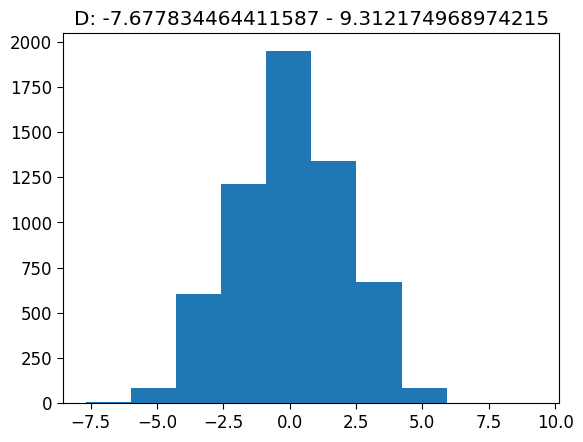

Q
(1983, 3, 3)
Z
(1983, 18)


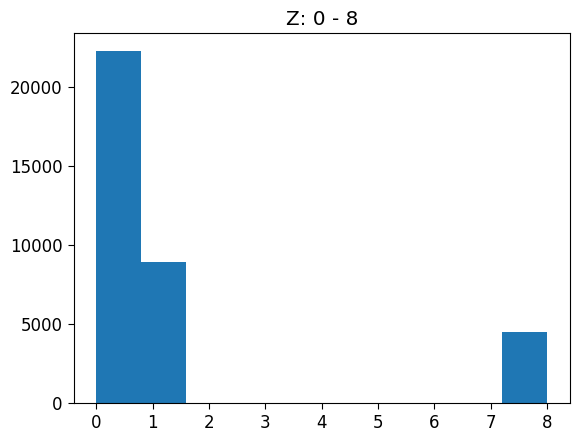

esp
(1983, 44510)


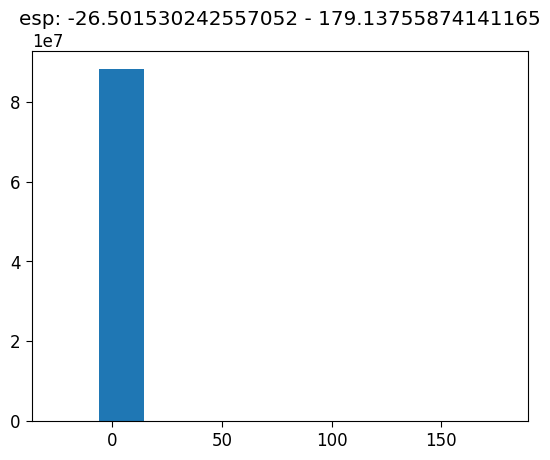

esp_grid
(1983, 44510, 3)
F
(1983, 18, 3)


In [9]:
for k in data_loaded.keys():
    
    print(k)
    shape = data_loaded[k].shape
    print(shape
    )
    if len(shape) < 3:
        try:
            d = data_loaded[k]
            d = d.flatten()
            plt.hist(d)
            title = f"{k}: {d.min()} - {d.max()}"
            plt.title(title)
            plt.show()
        except:
            pass

In [10]:
prepare_datasets?

Signature:
prepare_datasets(
    key,
    num_train,
    num_valid,
    filename,
    clean=False,
    esp_mask=False,
    clip_esp=False,
    natoms=60,
)
Docstring:
Prepare datasets for training and validation.

Wrapper function that calls prepare_multiple_datasets and then
creates train/validation splits and dictionaries.

Parameters
----------
key : jax.random.PRNGKey
    Random key for dataset shuffling
num_train : int
    Number of training samples
num_valid : int
    Number of validation samples
filename : str or list
    Filename(s) to load datasets from
clean : bool, optional
    Whether to filter failed calculations, by default False
esp_mask : bool, optional
    Whether to create ESP masks, by default False
clip_esp : bool, optional
    Whether to clip ESP to first 1000 points, by default False
natoms : int, optional
    Maximum number of atoms per system, by default 60

Returns
-------
tuple
    A tuple containing train_data and valid_data dictionaries
File:      ~/mmml/mmm

In [11]:
n_sample = 1000  # Number of points to keep
data_key = jax.random.PRNGKey(0)

train_data, valid_data = prepare_datasets(
    data_key, num_train=1000, num_valid=100,
    filename=[data_path_resolved],
    clean=False, esp_mask=False,
    natoms=18,
    clip_esp=False,
)


shape (1983, 18, 3)
D (1983, 3)
Q 3 (1983, 3, 3) 1983
Q (1983, 3, 3)
R (1983, 18, 3)
(1983, 18, 3)
['R', 'Z', 'F', 'esp', 'D', 'esp_grid', 'Q']
1983
0 R 1983 (1983, 18, 3)
1 Z 1983 (1983, 18)
2 F 1983 (1983, 18, 3)
3 esp 1983 (1983, 44510)
4 D 5949 (5949, 1)
5 esp_grid 1983 (1983, 44510, 3)
6 Q 1983 (1983, 3, 3)


In [12]:

def random_sample_esp(esp, esp_grid, n_sample, seed=42):
    np.random.seed(seed)
    sampled_esp = []
    sampled_grid = []
    
    for i in range(len(esp)):
        lessthan = esp[i] < 2
        morethan = esp[i] > -2
        not_0 = esp[i] != 0.0
        condmask = lessthan*morethan*not_0
        _shape = esp[i][condmask].shape[0]
        print(_shape)
        indices = np.random.choice(_shape, n_sample, replace=False)
        indices = np.sort(indices) 
        sampled_esp.append(esp[i][condmask][indices])
        sampled_grid.append(esp_grid[i][condmask][indices])
    
    return np.array(sampled_esp), np.array(sampled_grid)

train_data["esp"], train_data["esp_grid"] = random_sample_esp(
    train_data["esp"] , train_data["esp_grid"], n_sample
)
valid_data["esp"], valid_data["esp_grid"] = random_sample_esp(
    valid_data["esp"] , valid_data["esp_grid"], n_sample
)


valid_data["esp"] = 0.0016 * valid_data["esp"]
train_data["esp"] = 0.0016 * train_data["esp"]

train_data["vdw_surface"] = train_data["esp_grid"] 
valid_data["vdw_surface"] = valid_data["esp_grid"] 
train_data["n_grid"] = np.full(len(train_data["vdw_surface"]), n_sample)
valid_data["n_grid"] = np.full(len(valid_data["vdw_surface"]), n_sample)


train_data["vdw_surface"] = train_data["esp_grid"]
valid_data["vdw_surface"] = valid_data["esp_grid"]

Hs_train = train_data["Z"] == 1.0
Os_train = train_data["Z"] == 8.0
Hs_valid = valid_data["Z"] == 1.0
Os_valid = valid_data["Z"] == 8.0

# train_data["mono"] = np.zeros_like(train_data["Z"])
# valid_data["mono"] = np.zeros_like(valid_data["Z"])

train_data["mono"] = Hs_train * 0.1 + Os_train * -0.2
valid_data["mono"] = Hs_valid * 0.1 + Os_valid * -0.2

# Fix n_grid shape
train_data["n_grid"] = np.full(train_data["Z"].shape[0], n_sample)
valid_data["n_grid"] = np.full(valid_data["Z"].shape[0], n_sample)

# Fix N shape  
train_data["N"] = np.count_nonzero(train_data["Z"], axis=1)
valid_data["N"] = np.count_nonzero(valid_data["Z"], axis=1)

13356
13219
14036
13138
13277
14079
13485
13517
12830
13404
13546
14464
13582
13244
14042
13206
13930
12995
27344
13195
13899
13747
13196
13455
31266
13205
13334
13251
12881
13901
13537
13531
13946
12921
13476
13091
13864
13668
13886
13085
13483
13301
30311
14099
31379
12633
13334
12569
12716
14037
13393
13341
27100
30602
13181
13043
13182
13315
13305
13947
13083
14081
13198
12599
14255
13867
13640
13318
13033
14172
13987
12859
12883
13398
13913
12857
13182
13268
13631
12950
13159
13973
13366
13130
13655
13397
13527
13095
13090
13716
12959
13795
13821
13817
13699
13576
12173
13275
13610
13518
12931
13300
12910
12867
13246
14334
12917
13972
12894
13955
12850
13655
13330
13683
14002
13882
13915
13815
14063
29873
13857
12971
13689
31432
12776
13794
12474
13707
14019
13652
13769
12474
13876
13955
13092
13982
31656
14110
13162
13175
14054
13290
13200
13450
13309
13041
13584
13228
13762
30695
31650
12673
12878
13370
13675
14163
13502
14011
13176
31024
13846
13128
14147
13760
14345
13420
1318

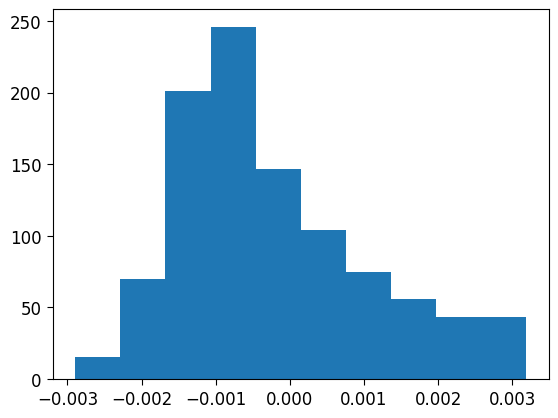

In [13]:
_ = plt.hist(valid_data["esp"][1])

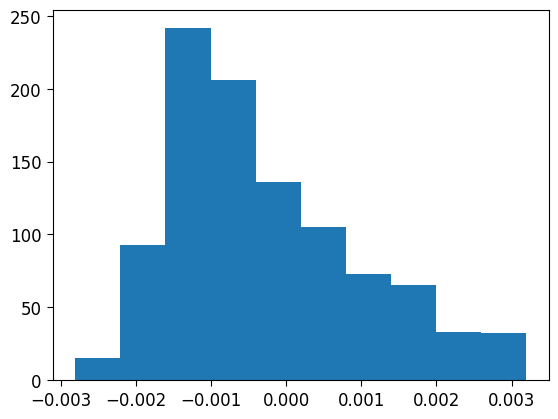

In [14]:
_ = plt.hist(valid_data["esp"][0])

In [15]:
# valid_data["esp"][0][lessthan * morethan ].shape

In [16]:
# Check current batch shapes
print("After fixes:")
batch = {k: v[0:1] if len(v.shape) > 0 else v for k, v in train_data.items()}
for key in ['mono', 'esp', 'vdw_surface', 'n_grid', 'N', 'R', 'Z']:
    if key in batch:
        print(f"{key}: {batch[key].shape}")

# Also check the specific values
print(f"\nmono values: {batch['mono']}")
print(f"N values: {batch['N']}")
print(f"n_grid values: {batch['n_grid']}")

After fixes:
mono: (1, 18)
esp: (1, 1000)
vdw_surface: (1, 1000, 3)
n_grid: (1,)
N: (1,)
R: (1, 18, 3)
Z: (1, 18)

mono values: [[-0.2  0.1  0.1 -0.2  0.1  0.1  0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. ]]
N values: [6]
n_grid values: [1000]


In [17]:
esp_data = train_data["esp"]
esp_data.shape

(1000, 1000)

## Training (1)

In [18]:
train_model?

Signature:     
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs,
    learning_rate,
    batch_size,
    writer,
    ndcm,
    esp_w=1.0,
    chg_w=0.01,
    restart_params=None,
    *,
    loss_step_fn: Callable = <PjitFunction of <function train_step at 0x7093357b4a40>>,
    eval_step_fn: Callable = <PjitFunction of <function eval_step at 0x709335347ba0>>,
    optimizer_fn: Callable = <function <lambda> at 0x709335368720>,
    use_ema: bool = True,
    ema_decay: float = 0.999,
    use_grad_clip: bool = True,
    grad_clip_norm: float = 2.0,
    log_extra_metrics: Optional[Callable] = <function _log_extra_metrics_none at 0x7093353685e0>,
    save_best_params_with_ema: bool = True,
    extra_valid_args: dict = None,
    extra_train_args: dict = {'chg_w': 0.01},
)
Call signature: train_model(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function train_model_general at 0x709335368540>, loss_step_fn=<PjitFunction of <...> etric

In [73]:
params, valid_loss = train_model(
    key=data_key, model=model,
    writer=None,
    train_data=train_data, valid_data=valid_data,
    num_epochs=100, learning_rate=1e-4, batch_size=1,
    restart_params=params if params is None else params,
    ndcm=model.n_dcm, esp_w=1.0, chg_w=0.0, use_grad_clip=True, grad_clip_norm=1.0,
)
new_params = params.copy()

Preparing batches
..................
Epoch 1 train: 5.5530374083900824e-05, valid: 0.0030992331448942423, best: True
Epoch 2 train: 7.406978511426132e-06, valid: 0.0008122118306346238, best: True
Epoch 3 train: 1.3589841728389729e-05, valid: 0.00031611070153303444, best: True
Epoch 4 train: 8.017535947146825e-06, valid: 0.00018130239914171398, best: True
Epoch 5 train: 7.701316462771501e-06, valid: 0.00012665307440329343, best: True
Epoch 6 train: 2.1096402633702382e-05, valid: 0.00016530552238691598, best: False
Epoch 7 train: 5.31017622051877e-06, valid: 0.0001061113434843719, best: True
Epoch 8 train: 6.069267783459509e-06, valid: 7.999601803021505e-05, best: True
Epoch 9 train: 5.637810318148695e-06, valid: 6.806161400163546e-05, best: True
Epoch 10 train: 5.393922947405372e-06, valid: 5.072450221632607e-05, best: True
Epoch 11 train: 5.119073648529593e-06, valid: 4.215572334942408e-05, best: True
Epoch 12 train: 5.421919468062697e-06, valid: 3.979307075496763e-05, best: True
Epoch

KeyboardInterrupt: 

In [20]:
import pandas as pd
params = pd.read_pickle("best_1.0_params.pkl")

In [21]:
params['params'].keys()



dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3', 'Dense_4', 'Dense_5', 'Dense_6', 'Embed_0', 'MessagePass_0', 'MessagePass_1', 'MessagePass_2', 'TensorDense_0', 'element_bias'])

In [22]:
from mmml.dcmnet.dcmnet.analysis import dcmnet_analysis, prepare_batch

?dcmnet_analysis
?prepare_batch
prepare_batches?

Signature:
prepare_batches(
    key,
    data,
    batch_size,
    include_id=False,
    data_keys=None,
    num_atoms=60,
    dst_idx=None,
    src_idx=None,
) -> list
Docstring:
Prepare batches for training.

Creates batches from the dataset for training. Handles message passing
indices and batch segmentation for equivariant operations.

Parameters
----------
key : jax.random.PRNGKey
    Random key for shuffling
data : dict
    Dictionary containing the dataset
batch_size : int
    Size of each batch
include_id : bool, optional
    Whether to include ID in the output, by default False
data_keys : list, optional
    List of keys to include in the output, by default None
num_atoms : int, optional
    Number of atoms per system, by default 60
dst_idx : array_like, optional
    Destination indices for message passing, by default None
src_idx : array_like, optional
    Source indices for message passing, by default None

Returns
-------
list
    A list of dictionaries, each representing a

In [23]:
prepare_batch_for_analysis?

Signature: prepare_batch_for_analysis(data, index=0)
Docstring: Prepare a single batch correctly for dcmnet_analysis.
File:      /tmp/ipykernel_562757/3446697203.py
Type:      function

In [24]:
batch["D"]

array([[-0.49501366]])

In [25]:
from mmml.dcmnet.dcmnet.data import prepare_batches
from mmml.dcmnet.dcmnet.analysis import dcmnet_analysis

def prepare_batch_for_analysis(data, index=0):
    """Prepare a single batch correctly for dcmnet_analysis."""
    # Extract single item but keep batch dimension
    _dict = {k: np.array(v[[index]]) for k, v in data.items()}
    
    # Use prepare_batches with include_id=True
    batch = prepare_batches(jax.random.PRNGKey(0), _dict, batch_size=1, include_id=False, num_atoms =18)[0]
    batch["com"] = np.array([0,0,0])
    batch["Dxyz"] = np.array([0,0,0])
    return batch

batch = prepare_batch_for_analysis(train_data, index=0)
output = dcmnet_analysis(params, model, batch, 18)
print(f"RMSE: {output['rmse_model']:.6f}")
print(f"RMSE (masked): {output['rmse_model_masked']:.6f}")

RMSE: 0.980922
RMSE (masked): 0.981360


In [28]:
from mmml.dcmnet.dcmnet.utils import apply_model
NATOMS = 18
_ = apply_model(model, params, batch, 1, NATOMS)

In [29]:
batch["R"][:6]

array([[-0.6063652 , -2.25301743, -0.96353722],
       [-0.10810471, -1.57766628, -1.44506454],
       [-0.08013535, -3.04872942, -1.01518822],
       [ 0.46990204,  1.26449585,  2.79917145],
       [-0.18730545,  0.67800903,  2.39485359],
       [ 0.03126526,  2.10784054,  2.89130402]])

In [30]:
6*4

24

In [31]:
m,d = _
# d.reshape(1, 18 * 4, 3)[0,:6*model.n_dcm]
d[:6*model.n_dcm]

Array([[-0.6063649 , -0.60634494, -0.6063796 ],
       [-0.60636127, -2.2530212 , -2.2530172 ],
       [-2.253014  , -2.2530355 , -0.9635218 ],
       [-0.9635381 , -0.9635371 , -0.963528  ],
       [-0.10810445, -0.10810996, -0.10809522],
       [-0.1081008 , -1.5776674 , -1.5776631 ],
       [-1.5776943 , -1.5776587 , -1.445064  ],
       [-1.4450642 , -1.4450618 , -1.445119  ],
       [-0.08013486, -0.08013894, -0.08013702],
       [-0.08013409, -3.0487294 , -3.0487294 ],
       [-3.0488    , -3.0487297 , -1.015188  ],
       [-1.0151821 , -1.0151877 , -1.015211  ],
       [ 0.4699021 ,  0.46986952,  0.46990976],
       [ 0.4698973 ,  1.2644995 ,  1.2644966 ],
       [ 1.2644624 ,  1.2644937 ,  2.799155  ],
       [ 2.7991638 ,  2.7991729 ,  2.799109  ],
       [-0.1873049 , -0.18730676, -0.18730557],
       [-0.1873082 ,  0.6780115 ,  0.6780086 ],
       [ 0.6780188 ,  0.67800695,  2.3948543 ],
       [ 2.3948574 ,  2.3948512 ,  2.3948915 ],
       [ 0.03126492,  0.03127126,  0.031

In [32]:
dcmnet_analysis

<function mmml.dcmnet.dcmnet.analysis.dcmnet_analysis(params, model, batch, NATOMS)>

In [33]:
batch

{'R': array([[-0.6063652 , -2.25301743, -0.96353722],
        [-0.10810471, -1.57766628, -1.44506454],
        [-0.08013535, -3.04872942, -1.01518822],
        [ 0.46990204,  1.26449585,  2.79917145],
        [-0.18730545,  0.67800903,  2.39485359],
        [ 0.03126526,  2.10784054,  2.89130402],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]]),
 'Z': array([8, 1, 1, 8, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'esp': array([[-1.90548487e-

In [34]:
import ase
from ase.visualize import view
atoms = ase.Atoms(batch["Z"][:int(batch["N"])], 
batch["R"][:int(batch["N"])])
view(atoms, viewer="x3d")


In [35]:
output.keys()
output["mono"].sum(axis=-1)

Array([[-0.19378017,  0.09705748,  0.09672599, -0.1936255 ,  0.09695166,
         0.0966705 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]], dtype=float32)

In [36]:
output["dipo"][:24]

Array([[-0.6063649 , -0.60634494, -0.6063796 ],
       [-0.60636127, -2.2530212 , -2.2530172 ],
       [-2.253014  , -2.2530355 , -0.9635218 ],
       [-0.9635381 , -0.9635371 , -0.963528  ],
       [-0.10810445, -0.10810996, -0.10809522],
       [-0.1081008 , -1.5776674 , -1.5776631 ],
       [-1.5776943 , -1.5776587 , -1.445064  ],
       [-1.4450642 , -1.4450618 , -1.445119  ],
       [-0.08013486, -0.08013894, -0.08013702],
       [-0.08013409, -3.0487294 , -3.0487294 ],
       [-3.0488    , -3.0487297 , -1.015188  ],
       [-1.0151821 , -1.0151877 , -1.015211  ],
       [ 0.4699021 ,  0.46986952,  0.46990976],
       [ 0.4698973 ,  1.2644995 ,  1.2644966 ],
       [ 1.2644624 ,  1.2644937 ,  2.799155  ],
       [ 2.7991638 ,  2.7991729 ,  2.799109  ],
       [-0.1873049 , -0.18730676, -0.18730557],
       [-0.1873082 ,  0.6780115 ,  0.6780086 ],
       [ 0.6780188 ,  0.67800695,  2.3948543 ],
       [ 2.3948574 ,  2.3948512 ,  2.3948915 ],
       [ 0.03126492,  0.03127126,  0.031

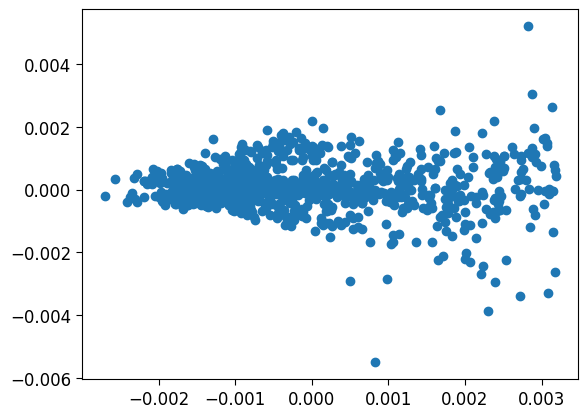

In [37]:
plt.scatter(batch["esp"], output['esp_pred'])

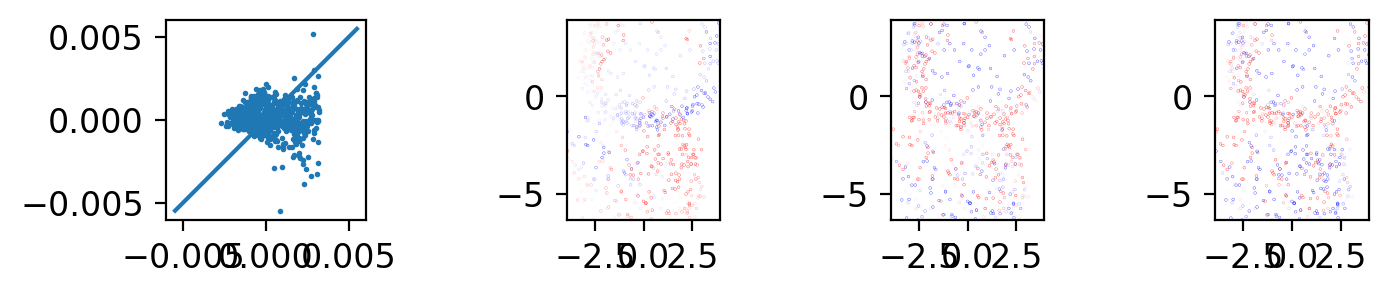

In [38]:
import patchworklib as pw
VMAX = 0.001
xy_ax = pw.Brick()
xy_ax.scatter(batch["esp"], output['esp_pred'], s=1)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
xy_ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
xy_ax.set_aspect('equal')

ax_true = pw.Brick()
Npoints = 1000
vdw_surface_min = np.min(batch["vdw_surface"][0], axis=-1)
vdw_surface_max = np.max(batch["vdw_surface"][0], axis=-1)

ax_true.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_true.set_aspect('equal')

ax_pred = pw.Brick()

ax_pred.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=output['esp_pred'][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_pred.set_aspect('equal')


ax_diff = pw.Brick()
ax_diff.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints] - output['esp_pred'][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
ax_diff.set_aspect('equal')

for _ in [ax_pred, ax_true, ax_diff]:
    _.set_xlim(vdw_surface_min[0], -vdw_surface_min[0])
    _.set_ylim(vdw_surface_min[1], -vdw_surface_min[0])


xy_ax | ax_pred | ax_true | ax_diff



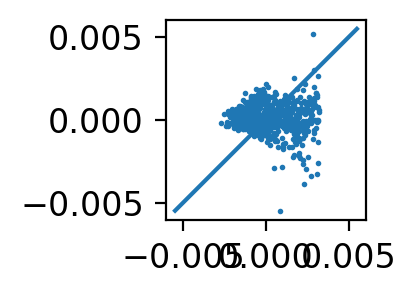

In [39]:
xy_ax

In [40]:
output["mono"][0][:int(batch["N"])].sum(axis=-1)


Array([-0.19378017,  0.09705748,  0.09672599, -0.1936255 ,  0.09695166,
        0.0966705 ], dtype=float32)

In [41]:
output["mono"][0][:int(batch["N"])*model.n_dcm]

Array([[-0.04673597, -0.0491851 , -0.04930143, -0.04855767],
       [ 0.02337889,  0.02469537,  0.02460891,  0.02437432],
       [ 0.02373109,  0.02440595,  0.02436241,  0.02422653],
       [-0.04690343, -0.04917854, -0.04923772, -0.04830579],
       [ 0.02350908,  0.0246089 ,  0.02452176,  0.02431192],
       [ 0.02378319,  0.02434532,  0.02431621,  0.02422579],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.

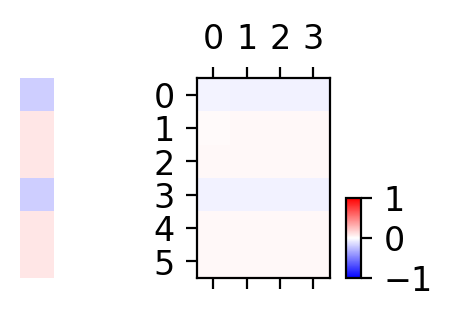

In [42]:
charge_ax = pw.Brick()
charge_ax.matshow(output["mono"][0][:int(batch["N"])],vmin=-1,vmax=1)
scharge_ax = pw.Brick()
scharge_ax.matshow(output["mono"][0][:int(batch["N"])].sum(axis=-1)[:, None],vmin=-1,vmax=1)
# scharge_ax.add_colorbar(vmin=-1,vmax=1)
scharge_ax.axis("off")
f = (scharge_ax | charge_ax)
f.add_colorbar(vmin=-1,vmax=1)

In [46]:
R = output["dipo"][:int(batch["N"])*NDCM]
Z = np.array([1 if _ > 0 else 1 for _ in output["mono"][0][:int(batch["N"])].flatten()])
R.shape, Z.shape
dcm_atoms = ase.Atoms(Z, R)
view(dcm_atoms,  viewer="x3d")

In [44]:
new_params, valid_loss = train_model(
    key=jax.random.PRNGKey(0), model=model,
    writer=None,
    train_data=train_data, valid_data=valid_data,
    num_epochs=100, learning_rate=5e-4, batch_size=1,
    ndcm=model.n_dcm, esp_w=1000.0,
    restart_params=params if new_params is None else new_params,
)

NameError: name 'new_params' is not defined

In [ ]:
key